In [18]:
import os
import glob

def get_tiff_files(directory):
    tiff_files = []
    for root, dirs, files in os.walk(directory):
        tiff_files.extend(glob.glob(os.path.join(root, '*.tiff')))
        tiff_files.extend(glob.glob(os.path.join(root, '*.tif')))
    return tiff_files

# Usage
start_directory = './'
tiff_files = get_tiff_files(start_directory)
for file in tiff_files:
    print(file)
csv_files = [f".{s.split('.')[-2]}_weather.csv" for s in tiff_files]
csv_files

./13/2019-05-17.tiff
./18/2021-05-02.tiff
./15/2020-04-22.tiff
./07/2021-06-03.tiff
./09/2021-06-16.tiff
./08/2021-06-08.tiff
./14/2019-05-28.tiff
./02/2021-06-03.tiff
./19/2021-05-04.tiff
./16/2020-05-09.tiff
./17/2020-05-26.tiff
./06/2021-06-03.tiff
./11/2018-06-01.tiff
./05/2021-06-03.tiff
./01/2021-05-26.tiff
./03/2021-06-03.tiff
./12/2019-05-10.tiff
./10/2021-06-16.tiff
./00/2021-06-06.tiff
./04/2021-06-06.tiff
./20/2021-05-15.tiff


['./13/2019-05-17_weather.csv',
 './18/2021-05-02_weather.csv',
 './15/2020-04-22_weather.csv',
 './07/2021-06-03_weather.csv',
 './09/2021-06-16_weather.csv',
 './08/2021-06-08_weather.csv',
 './14/2019-05-28_weather.csv',
 './02/2021-06-03_weather.csv',
 './19/2021-05-04_weather.csv',
 './16/2020-05-09_weather.csv',
 './17/2020-05-26_weather.csv',
 './06/2021-06-03_weather.csv',
 './11/2018-06-01_weather.csv',
 './05/2021-06-03_weather.csv',
 './01/2021-05-26_weather.csv',
 './03/2021-06-03_weather.csv',
 './12/2019-05-10_weather.csv',
 './10/2021-06-16_weather.csv',
 './00/2021-06-06_weather.csv',
 './04/2021-06-06_weather.csv',
 './20/2021-05-15_weather.csv']

In [19]:
import rasterio
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report

import numpy as np
from scipy.ndimage import generic_filter

def calculate_additional_features(red, green, blue, nir):
    # Existing NDVI calculation
    ndvi = (nir - red) / (1e-3 + nir + red)
    
    # Enhanced Vegetation Index (EVI)
    evi = 2.5 * (nir - red) / (1e-3 + nir + 6 * red - 7.5 * blue + 1)
    
    # Soil Adjusted Vegetation Index (SAVI)
    savi = ((nir - red) / (nir + red + 0.5)) * 1.5
    
    # Normalized Difference Water Index (NDWI)
    ndwi = (green - nir) / (1e-3 + green + nir)
    
    # Simple Ratio (SR)
    sr = nir / (1e-3 + red)
    
    # Green Normalized Difference Vegetation Index (GNDVI)
    gndvi = (nir - green) / (1e-3 + nir + green)
    
    # Texture features (example: local entropy)
    def entropy(values):
        values = values.flatten()
        h, _ = np.histogram(values, bins=20)
        h = h / h.sum()
        return -np.sum(h * np.log2(h + (h == 0)))
    
    entropy_red =0# generic_filter(red, entropy, size=5)
    entropy_nir =0# generic_filter(nir, entropy, size=5)
    
    return ndvi, evi, savi, ndwi, sr, gndvi, entropy_red, entropy_nir

# In your main processing function:
def load_and_preprocess_tiff(file_path, r_band, g_band, b_band, ik_band, mask_band):
    with rasterio.open(file_path) as src:
        red = src.read(r_band)
        green = src.read(g_band)
        blue = src.read(b_band)
        nir = src.read(ik_band)
        mask = src.read(mask_band)
    
    ndvi, evi, savi, ndwi, sr, gndvi, entropy_red, entropy_nir = calculate_additional_features(red, green, blue, nir)
    
    # Create a DataFrame with pixel-level information
    pixel_data = pd.DataFrame({
        'red': red.flatten(),
        'green': green.flatten(),
        'blue': blue.flatten(),
        'nir': nir.flatten(),
        'ndvi': ndvi.flatten(),
        'evi': evi.flatten(),
        'savi': savi.flatten(),
        'ndwi': ndwi.flatten(),
        'sr': sr.flatten(),
        'gndvi': gndvi.flatten(),
        #'entropy_red': entropy_red.flatten(),
        #'entropy_nir': entropy_nir.flatten(),
        'mask': mask.flatten()
    })
    
    return pixel_data


In [20]:
import pandas as pd
import numpy as np
def process_csv(csv_file):
    # Read the CSV file
    csv_data = pd.read_csv(csv_file,sep = ',').iloc[:,1:]
    
    # Take only the last 10 rows
    last_10_rows = csv_data.tail(10)
    
    # Calculate the mean for each feature
    mean_values = last_10_rows.mean()
    
    # If there's no data, the mean will be NaN
    return mean_values



all_pixel_data = []
all_csv_data = []

for tiff_file, csv_file in tqdm(zip(tiff_files, csv_files)):
    pixel_data = load_and_preprocess_tiff(tiff_file, r_band=1, g_band=2, b_band=3, ik_band=4, mask_band=5)
    csv_mean_data = process_csv(csv_file)
    
    # Step 2: Combine pixel-level and panorama-level data
    csv_data_expanded = pd.DataFrame(np.tile(csv_mean_data.values, (len(pixel_data), 1)), 
                                     columns=csv_mean_data.index)
    combined_data = pd.concat([pixel_data, csv_data_expanded], axis=1)
    
    all_pixel_data.append(combined_data)

# Combine all data
final_data = pd.concat(all_pixel_data, ignore_index=True)

# The rest of the code remains the same...
X = final_data.drop('mask', axis=1)
y = final_data['mask']

0it [00:00, ?it/s]

In [41]:
# Handle missing values
X = X.fillna(-100)

import catboost as cb
from lightgbm import LGBMClassifier

# Encode categorical variables if present
# X = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Address class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Step 5: Train and evaluate the XGBoost model
model = xgb.XGBClassifier(random_state=42,iterations = 500)
model.fit(X_train_balanced, y_train_balanced,verbose = 100)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# Step 7: Interpret the results
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 important features:")
print(feature_importance.head(10))


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2b6a8e6d40>
Traceback (most recent call last):
  File "/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/kglin/miniconda3/envs/central_bank/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
     

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    960826
         1.0       0.27      0.82      0.41     50866

    accuracy                           0.88   1011692
   macro avg       0.63      0.85      0.67   1011692
weighted avg       0.95      0.88      0.91   1011692

Top 10 important features:
                    feature  importance
11                     Тмин    0.322684
8                        sr    0.089659
12                    Тмакс    0.067875
2                      blue    0.065072
14        Направление ветра    0.063387
17  Давление на уровне моря    0.049741
15           Скорость ветра    0.044724
13             Осадки всего    0.042888
1                     green    0.037730
5                       evi    0.034897


In [42]:
cb_model = cb.CatBoostClassifier(random_state=42,iterations = 500)
cb_model.fit(X_train_balanced, y_train_balanced,verbose = 100)


Learning rate set to 0.5
0:	learn: 0.5216461	total: 393ms	remaining: 3m 16s
100:	learn: 0.2507308	total: 36.2s	remaining: 2m 23s
200:	learn: 0.2248847	total: 1m 12s	remaining: 1m 47s
300:	learn: 0.2184188	total: 1m 47s	remaining: 1m 11s
400:	learn: 0.2144262	total: 2m 22s	remaining: 35.2s
499:	learn: 0.2115780	total: 2m 59s	remaining: 0us


In [43]:
cb_pred_proba = cb_model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
xgb_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
y_pred_proba = (cb_pred_proba+xgb_pred_proba)/2.0

In [50]:
cb_model.save_model('model',
           format="cbm",
           export_parameters=None,
           pool=None)

###### Calculate ROC-AUC score
from sklearn.metrics import classification_report, roc_auc_score,roc_curve
%pylab inline

#y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

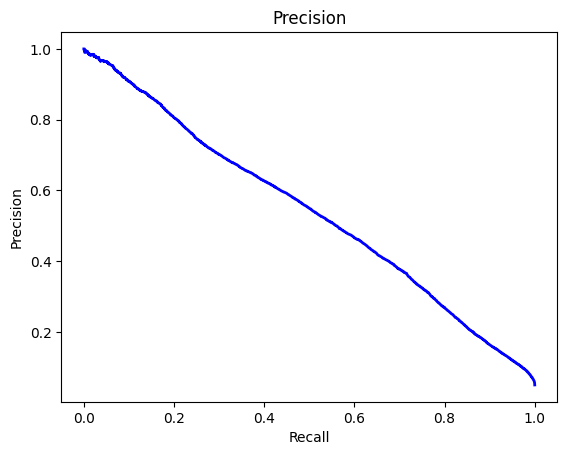

0.540795927274295

In [36]:
# Handle missing values
X = X.fillna(-100)

import catboost as cb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision')
plt.show()
average_precision

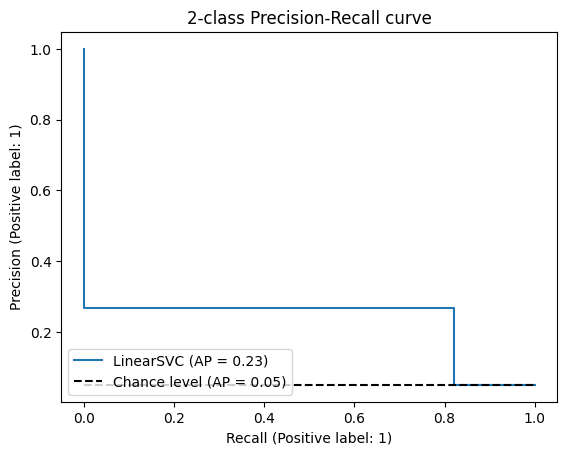

In [47]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    y_test, model.predict(X_test), name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")


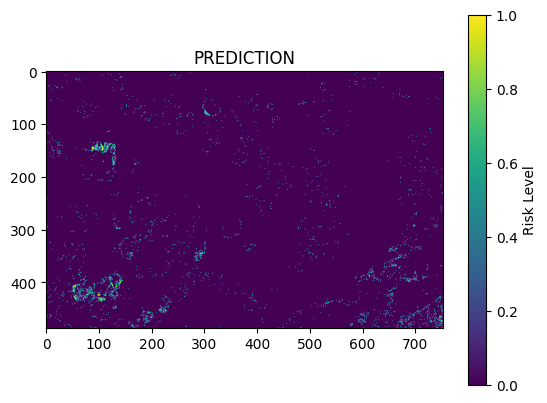

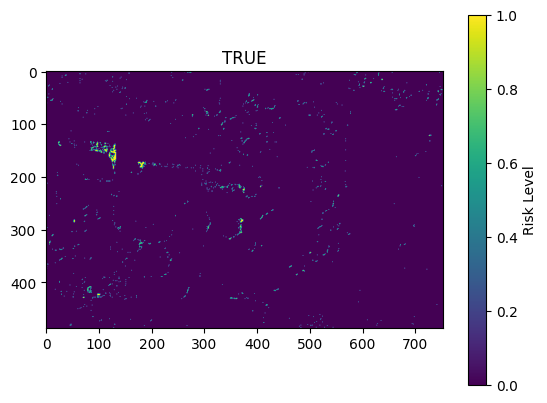

In [39]:
# Visualize predictions on original panorama (example for one image)
with rasterio.open(tiff_files[0]) as src:
    original_shape = src.read(1).shape

predictions = model.predict_proba(X)[:487*753][:,1]
prediction_image = predictions.reshape(original_shape)

import matplotlib.pyplot as plt
plt.title("PREDICTION")
plt.imshow((prediction_image)[:,:]>0.2)
plt.colorbar(label="Risk Level")
plt.show()
plt.imshow(y[:487*753].values.reshape(original_shape)[:,:])
plt.title("TRUE")
plt.colorbar(label="Risk Level")
plt.show()

In [40]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

# Assuming you have already trained your model and have X_test and y_test

# Get the predicted probabilities instead of class predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Define the range of thresholds to try
thresholds = np.arange(0, 1.01, 0.01)

# Initialize variables to store the best results
best_mcc = -1
best_threshold = 0

# Perform the threshold sweep
for threshold in tqdm(thresholds):
    # Convert probabilities to binary predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate MCC
    mcc = matthews_corrcoef(y_test*2-1, y_pred*2-1)
    
    # Update best results if current MCC is higher
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

# Print the results
print(f"Best threshold: {best_threshold:.2f}")
print(f"Best MCC: {best_mcc:.4f}")

# Use the best threshold to make final predictions
final_predictions = (y_pred_proba >= best_threshold).astype(int)

# Calculate final MCC (this should be the same as best_mcc)
final_mcc = matthews_corrcoef(y_test, final_predictions)
print(f"Final MCC: {final_mcc:.4f}")


  0%|          | 0/101 [00:00<?, ?it/s]

Best threshold: 0.83
Best MCC: 0.5028
Final MCC: 0.5028


In [17]:
import overpy
import numpy as np
import requests
import os
import elevation

def get_osm_data(lat, lon, radius=1000):
    api = overpy.Overpass()
    bbox = f"{lat-0.01},{lon-0.01},{lat+0.01},{lon+0.01}"
    return api, bbox

def query_feature(api, feature, bbox):
    query = f"""
    [out:json];
    (
      {feature}({bbox});
    );
    out body;
    >;
    out skel qt;
    """
    return api.query(query)

def get_forests(api, bbox):
    return query_feature(api, 'way["landuse"="forest"]', bbox)

def get_water_bodies(api, bbox):
    return query_feature(api, 'way["natural"="water"]', bbox)

def get_roads(api, bbox):
    return query_feature(api, 'way["highway"]', bbox)

def get_buildings(api, bbox):
    return query_feature(api, 'way["building"]', bbox)

def get_power_lines(api, bbox):
    return query_feature(api, 'way["power"="line"]', bbox)

def get_elevation_data(lat, lon, size=3):
    # Download a small area of elevation data
    area = (lon-0.001*size, lat-0.001*size, lon+0.001*size, lat+0.001*size)
    elevation.clip(bounds=area, output='./elevation.tif')
    
    # Read the elevation data
    with open('/home/kglin/.cache/elevation/SRTM1/elevation.tif', 'rb') as f:
        f.seek(64)  # Skip the header
        elevation_data = np.frombuffer(f.read(), dtype='>f4').reshape((size, size))
        
    return elevation_data

def calculate_elevation_and_slope(lat, lon):
    elevation_data = get_elevation_data(lat, lon)
    
    # Get elevation at the center point
    elevation = elevation_data[1, 1]
    
    # Calculate slope
    dx = ((elevation_data[0, 2] + 2*elevation_data[1, 2] + elevation_data[2, 2]) - 
          (elevation_data[0, 0] + 2*elevation_data[1, 0] + elevation_data[2, 0])) / 8
    dy = ((elevation_data[2, 0] + 2*elevation_data[2, 1] + elevation_data[2, 2]) - 
          (elevation_data[0, 0] + 2*elevation_data[0, 1] + elevation_data[0, 2])) / 8
    
    slope_degrees = np.degrees(np.arctan(np.sqrt(dx*dx + dy*dy) / 0.00333))  # 0.00333 is approx. 111km/degree * 0.00003
    
    return elevation, slope_degrees

def collect_fire_risk_data(lat, lon):
    api, bbox = get_osm_data(lat, lon)
        
    data = {
        "forests": get_forests(api, bbox),
        "water_bodies": get_water_bodies(api, bbox),
        "roads": get_roads(api, bbox),
        "buildings": get_buildings(api, bbox),
        "power_lines": get_power_lines(api, bbox),
    }
    return data

In [16]:
fire_risk_data = collect_fire_risk_data(lat, lon)

# Process and analyze the data as needed
for feature, result in fire_risk_data.items():
    print(f"{feature}: {len(result.ways)} ways found")

forests: 0 ways found
water_bodies: 0 ways found
roads: 3262 ways found
buildings: 3779 ways found
power_lines: 0 ways found
